<a href="https://colab.research.google.com/github/futartup/S12-assignment/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Add the current path to system path so that it can find the custom libraries

In [0]:
import os, sys
path_current = '/content/drive/My Drive/Colab Notebooks/S11'
if '/content/drive/My Drive/Colab Notebooks/S11' not in sys.path:
  sys.path.append(path_current)

# Import all the custom and inbuilt modules

drive  sample_data


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


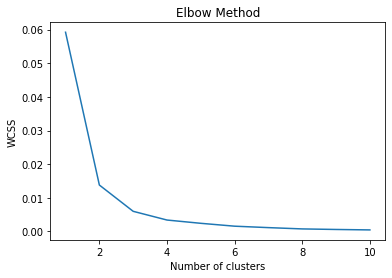

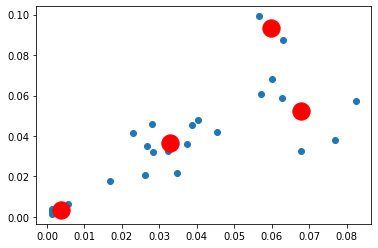

In [6]:
!ls 
try:
  import ipynb
except:
  !pip install ipynb --upgrade
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torch.optim as optim
import os, sys

from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional as F



# custom apis
from ipynb.fs.full.transform_train_test_loader import *


from ipynb.fs.full.train import train_model
from ipynb.fs.full.copy_test import test_model
from ipynb.fs.full.utils import *
from ipynb.fs.full.lr_finder import *
# import gradcam 
from ipynb.fs.full.resnet_gradcam import *
import json
import pandas as pd


# import K means clustering
from ipynb.fs.full.K_means_clustering import make_clusters
import ipynb.fs.full.conf as conf
if conf.make_cluster:
  with open(path_current + conf.file_path, 'r') as fp:
    file_content = json.load(fp)
    make_clusters(file_content)
  


# The model related code. Load the model from the conf file. 

In [0]:

if conf.custom_model['use']:
  #use custom model
  pass
elif conf.inbuilt_model['use']:
  from ipynb.fs.full.model.pytorch_resnet import *
  from ipynb.fs.full.model.resnet import *
  from ipynb.fs.full.model.s11_resnet_dnn import NetS11
  model_type = conf.inbuilt_model['model']
  if model_type == 'DenseNet':
    net = globals()[model_type](growthRate=12, depth=50, reduction=0.5,
                            bottleneck=True, nClasses=10)
  else:
    net = globals()[model_type]()
  #net = torchvision.models.resnet18(pretrained=False)

# Model Summary

In [5]:
use_cuda = torch.cuda.is_available()
if use_cuda:
  torch.cuda.manual_seed(conf.seed)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [

# Test and Train loader

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.031203836956604647, **conf.optimizer_parameters)

data_loader_obj = DataLoaderA(conf, './data')
data_loader_obj.download_images("http://cs231n.stanford.edu/tiny-imagenet-200.zip")
train_loader = data_loader_obj.get_train_loader()
test_loader = data_loader_obj.get_test_loader()
print(len(train_loader))
print(len(test_loader))

196
20


## Scheduler Call and LR Range finder

In [0]:
#lr_range_obj = LRRangeFinder(model=model, epochs=10, start_lr=1e-7, end_lr=1.0, dataloader=train_loader, trainlen=len(train_loader), batch_size=conf.batch_size, device=device)
#max_lr = lr_range_obj.findLR()
#print(max_lr)


# Visualize the transformed images

In [0]:
classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

# images, labels = next(iter(train_loader))
# images = images.numpy()  # convert images to numpy for display

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(32, 32))
# # display 20 images
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
#     ax.imshow(images[idx].transpose((1, 2, 0)))
#     ax.set_title(classes[labels[idx].item()])

# Find the best LR

In [0]:
if conf.use_lr_finder_train:
  lr_finder = LRFinder(model, optimizer, criterion, device) #implemented LRFinder for SGD
  lr_finder.range_test(train_loader, end_lr=5, num_iter=len(train_loader)*10, step_mode="exp")
  lr_finder.plot() # to inspect the loss-learning rate graph
  #print(lr_finder.history) # see the history
  best_loss = lr_finder.best_loss
  print(min(lr_finder.history['lr']))
  print(lr_finder.history['lr'][lr_finder.history['loss'].index(best_loss)])
  optimizer.lr = lr_finder.history['lr'][lr_finder.history['loss'].index(best_loss)]
  lr_finder.reset()
  loss = lr_finder.history['loss']
  lr = lr_finder.history['lr']
  print(lr[loss.index(min(loss))])

  #max_lr = min(lr_finder.history['lr'])
scheduler = conf.scheduler(optimizer, **conf.scheduler_parameters )

# Make Bounding Boxes

NameError: ignored

# Test and Train

In [9]:
# Containers to plot the graph for test and train
test_losses = []
test_acc = []
train_losses = []
train_acc = []

lr_array = []

# Containers for correctly and falsely predicted images
correct_predicted = []
false_predicted = []

# Number of images to display which are correct and false predicted
sample_count = 25

# TODO: Take the end epoch value from conf file 
for e in range(1, conf.epochs):
    print("epoch no: {}\n".format(e))
    #print("Learning rate : {}\n".format(scheduler.get_lr()))
    train_model(model, device, 
                train_loader, optimizer, 
                criterion, e,
                train_losses, train_acc, lr_array, scheduler)
    #scheduler.step()
    test_loss = test_model(model, device, 
                           test_loader, criterion, 
                           2, sample_count,
                           correct_predicted, false_predicted, 
                           test_losses, test_acc, e)
    scheduler.step(test_loss)
    print("===========================================================\n")



  0%|          | 0/196 [00:00<?, ?it/s]

epoch no: 1



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=11.965507507324219 Batch_id=195 Accuracy=4.82: 100%|██████████| 196/196 [00:57<00:00,  3.44it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 0/10000 (0.00%)


epoch no: 2



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 10/10000 (0.10%)


epoch no: 3



Loss=5.539604663848877 Batch_id=195 Accuracy=7.66: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0111, Accuracy: 140/10000 (1.40%)


epoch no: 4



Loss=5.1818976402282715 Batch_id=195 Accuracy=8.72: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0117, Accuracy: 49/10000 (0.49%)


epoch no: 5



Loss=5.115059852600098 Batch_id=195 Accuracy=9.34: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0118, Accuracy: 41/10000 (0.41%)


epoch no: 6



  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0119, Accuracy: 126/10000 (1.26%)


epoch no: 7



Loss=4.986560821533203 Batch_id=195 Accuracy=10.27: 100%|██████████| 196/196 [00:55<00:00,  3.53it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0125, Accuracy: 111/10000 (1.11%)


epoch no: 8



Loss=4.801687717437744 Batch_id=195 Accuracy=10.79: 100%|██████████| 196/196 [00:55<00:00,  3.53it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0122, Accuracy: 55/10000 (0.55%)


epoch no: 9



Loss=4.679557800292969 Batch_id=195 Accuracy=11.21: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0116, Accuracy: 341/10000 (3.41%)


epoch no: 10



Loss=4.7967681884765625 Batch_id=195 Accuracy=11.44: 100%|██████████| 196/196 [00:55<00:00,  3.54it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 55/10000 (0.55%)


epoch no: 11



Loss=4.904595851898193 Batch_id=195 Accuracy=11.62: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0124, Accuracy: 232/10000 (2.32%)


epoch no: 12



Loss=4.644622802734375 Batch_id=195 Accuracy=11.88: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 8/10000 (0.08%)


epoch no: 13



Loss=4.637186050415039 Batch_id=195 Accuracy=12.03: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0141, Accuracy: 14/10000 (0.14%)


epoch no: 14



Loss=4.753986835479736 Batch_id=195 Accuracy=12.12: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 50/10000 (0.50%)


epoch no: 15



Loss=4.346215724945068 Batch_id=195 Accuracy=15.67: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 130/10000 (1.30%)


epoch no: 16



Loss=4.265314102172852 Batch_id=195 Accuracy=16.96: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0130, Accuracy: 92/10000 (0.92%)


epoch no: 17



Loss=4.152549743652344 Batch_id=195 Accuracy=16.98: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0128, Accuracy: 122/10000 (1.22%)


epoch no: 18



Loss=4.115107536315918 Batch_id=195 Accuracy=17.24: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 67/10000 (0.67%)


epoch no: 19



Loss=4.140362739562988 Batch_id=195 Accuracy=17.43: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 26/10000 (0.26%)


epoch no: 20



Loss=4.024094104766846 Batch_id=195 Accuracy=17.52: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0129, Accuracy: 86/10000 (0.86%)


epoch no: 21



Loss=4.2231292724609375 Batch_id=195 Accuracy=17.57: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 115/10000 (1.15%)


epoch no: 22



Loss=4.221675395965576 Batch_id=195 Accuracy=17.93: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 98/10000 (0.98%)


epoch no: 23



Loss=4.367516040802002 Batch_id=195 Accuracy=17.96: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0132, Accuracy: 143/10000 (1.43%)


epoch no: 24



Loss=4.21083402633667 Batch_id=195 Accuracy=17.91: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 78/10000 (0.78%)


epoch no: 25



Loss=4.191219806671143 Batch_id=195 Accuracy=18.20: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 154/10000 (1.54%)


epoch no: 26



Loss=4.048868179321289 Batch_id=195 Accuracy=20.16: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 76/10000 (0.76%)


epoch no: 27



Loss=3.8167712688446045 Batch_id=195 Accuracy=20.83: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 89/10000 (0.89%)


epoch no: 28



Loss=3.925936222076416 Batch_id=195 Accuracy=20.89: 100%|██████████| 196/196 [00:55<00:00,  3.51it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 78/10000 (0.78%)


epoch no: 29



Loss=4.025677680969238 Batch_id=195 Accuracy=20.93: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 76/10000 (0.76%)


epoch no: 30



Loss=3.873833656311035 Batch_id=195 Accuracy=21.43: 100%|██████████| 196/196 [00:57<00:00,  3.41it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0133, Accuracy: 82/10000 (0.82%)


epoch no: 31



Loss=4.030157089233398 Batch_id=195 Accuracy=21.39: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 67/10000 (0.67%)


epoch no: 32



Loss=3.952918291091919 Batch_id=195 Accuracy=21.34: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 91/10000 (0.91%)


epoch no: 33



Loss=3.9253101348876953 Batch_id=195 Accuracy=21.44: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 74/10000 (0.74%)


epoch no: 34



Loss=3.7887380123138428 Batch_id=195 Accuracy=21.53: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 101/10000 (1.01%)


epoch no: 35



Loss=4.036953926086426 Batch_id=195 Accuracy=21.68: 100%|██████████| 196/196 [00:56<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 77/10000 (0.77%)


epoch no: 36



Loss=4.101102828979492 Batch_id=195 Accuracy=21.56: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0131, Accuracy: 80/10000 (0.80%)


epoch no: 37



Loss=3.767782688140869 Batch_id=195 Accuracy=22.17: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 77/10000 (0.77%)


epoch no: 38



Loss=3.8800110816955566 Batch_id=195 Accuracy=22.33: 100%|██████████| 196/196 [00:55<00:00,  3.52it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 77/10000 (0.77%)


epoch no: 39



Loss=3.883329153060913 Batch_id=195 Accuracy=22.34: 100%|██████████| 196/196 [00:55<00:00,  3.50it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 78/10000 (0.78%)


epoch no: 40



Loss=3.811946392059326 Batch_id=195 Accuracy=22.40: 100%|██████████| 196/196 [00:56<00:00,  3.45it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 76/10000 (0.76%)


epoch no: 41



Loss=4.0968780517578125 Batch_id=195 Accuracy=22.34: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 81/10000 (0.81%)


epoch no: 42



Loss=3.88059663772583 Batch_id=195 Accuracy=22.40: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 62/10000 (0.62%)


epoch no: 43



Loss=3.821013927459717 Batch_id=195 Accuracy=22.49: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 91/10000 (0.91%)


epoch no: 44



Loss=3.860477924346924 Batch_id=195 Accuracy=22.45: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Accuracy: 92/10000 (0.92%)


epoch no: 45



Loss=4.077830791473389 Batch_id=195 Accuracy=22.59: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 82/10000 (0.82%)


epoch no: 46



Loss=3.6660618782043457 Batch_id=195 Accuracy=22.55: 100%|██████████| 196/196 [00:56<00:00,  3.49it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 84/10000 (0.84%)


epoch no: 47



Loss=3.8533387184143066 Batch_id=195 Accuracy=22.49: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 89/10000 (0.89%)


epoch no: 48



Loss=3.860156774520874 Batch_id=195 Accuracy=22.69: 100%|██████████| 196/196 [00:56<00:00,  3.48it/s]
  0%|          | 0/196 [00:00<?, ?it/s]


Test set: Average loss: 0.0135, Accuracy: 81/10000 (0.81%)


epoch no: 49



Loss=3.835296392440796 Batch_id=195 Accuracy=22.63: 100%|██████████| 196/196 [00:56<00:00,  3.47it/s]



Test set: Average loss: 0.0135, Accuracy: 88/10000 (0.88%)




# *GradCam* for Resnet for falsely predicted images


In [0]:
# images = [x['image'].unsqueeze(0) for x in false_predicted]
# inputs = [i.to(device) for i in images]
# gradcamof(model, inputs, classes)

# Correctly predicted images

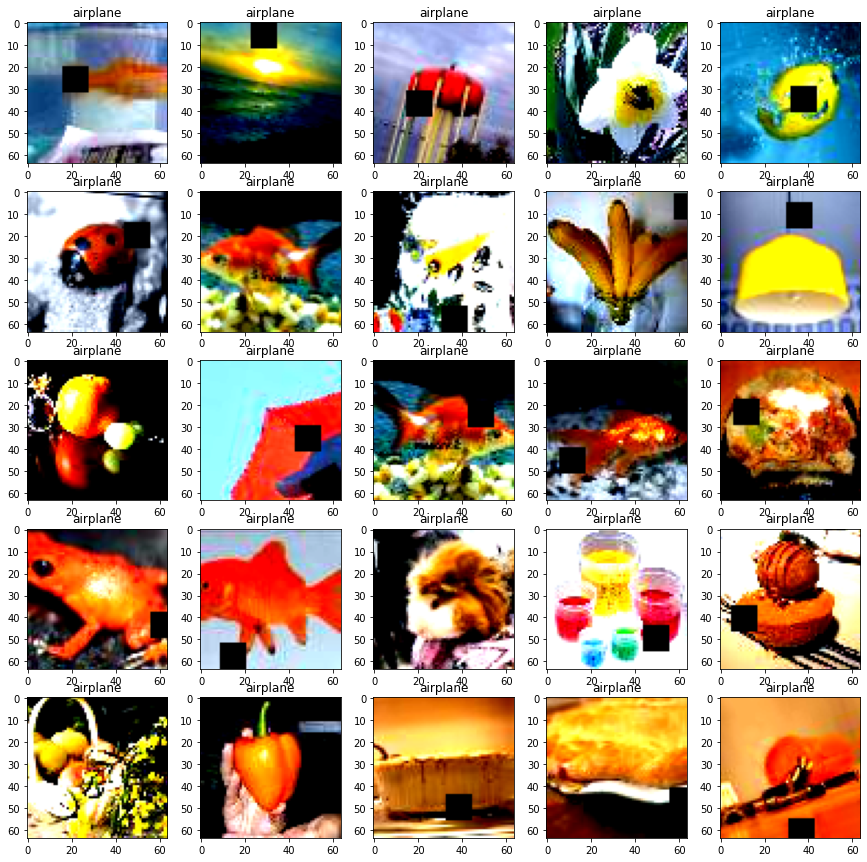

In [11]:
matplotlib_imshow(classes, correct_predicted, plt, False)

# Falsely predicted images

KeyError: ignored

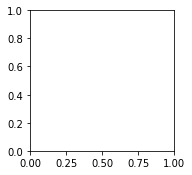

In [12]:
matplotlib_imshow(classes, false_predicted, plt, False)

# Plot The Graph for train and test 

In [0]:
plottesttraingraph([x.item() for x in train_losses], train_acc, test_losses, test_acc, plt, True)